# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [2]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [3]:
bandit0 = BanditProblem(0)

In [4]:
bandit0.get_num_arms()

3

In [5]:
bandit0.get_reward(arm=0)

1.8255111545554434

arm 0: mean=0.8319, std=0.8187, p(reward=0)=0.1556, max=6.7825
arm 1: mean=0.6068, std=0.6742, p(reward=0)=0.2617, max=4.8232
arm 2: mean=0.9041, std=0.8199, p(reward=0)=0.1084, max=4.9981


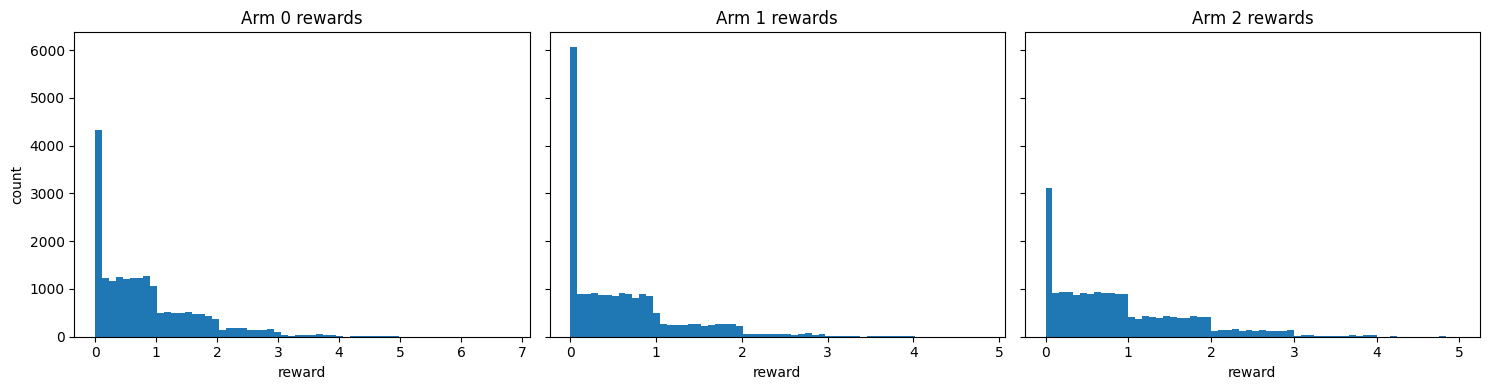

In [8]:
# YOUR CHANGES HERE

import matplotlib.pyplot as plt

bandit0 = BanditProblem(0)
K = bandit0.get_num_arms()

N = 20000  # samples per arm for exploration

samples = []
for arm in range(K):
    rewards = np.array([bandit0.get_reward(arm) for _ in range(N)])
    samples.append(rewards)

# Summary stats
for arm in range(K):
    r = samples[arm]
    print(
        f"arm {arm}: mean={r.mean():.4f}, std={r.std():.4f}, "
        f"p(reward=0)={(r==0).mean():.4f}, max={r.max():.4f}"
    )

# Histograms
fig, axes = plt.subplots(1, K, figsize=(15, 4), sharey=True)
for arm in range(K):
    axes[arm].hist(samples[arm], bins=60)
    axes[arm].set_title(f"Arm {arm} rewards")
    axes[arm].set_xlabel("reward")
axes[0].set_ylabel("count")
plt.tight_layout()
plt.show()


Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and give a single sentence justifying your choice and rejecting the alternatives.
Keep your explanation concise; you should be able to justify your choice solely based on the type of numbers observed, and whether those match the bandit algorithms that you have learned.

Rewards are continuous and bounded with a mass at zero (from the binomial draw).

Since the reward distribution is not Bernoulli, a Beta-Bernoulli Bayesian method isn’t directly appropriate without approximation.

UCB1 is appropriate because it makes minimal assumptions beyond bounded rewards and gives principled exploration via an optimism bonus.

(Optional) You can normalize rewards by dividing by 9 so they fit the standard UCB1 assumptions in [0,1].

In [11]:
content = (
    "Algorithm choice explanation:\n\n"
    "Rewards are continuous and bounded with a large spike at 0.\n"
    "Arm 2 has the highest mean reward and the lowest probability of zero reward,\n"
    "making it the expected best-performing arm.\n"
    "Since the reward distribution is not Bernoulli, a Beta-Bernoulli Bayesian method would not be not best without approximation.\n"
    "I think UCB1 is the best choice because it does not make many assumptions beyond bounded" 
    "rewards and gives exploration a bonus.\n"
    "I can normalize the rewards by dividing by 9 so they fit the standard UCB1 assumptions in [0,1]."
)

with open("algorithm-choice.txt", "w") as f:
    f.write(content)

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2026.

In [12]:
# YOUR CHANGES HERE

# bandit environment w 2026 seed
bandit = BanditProblem(seed=2026)
K = bandit.get_num_arms()

T = 1000
max_reward = 9.0  # rewards are bounded above by ns[arm], and ns in [1,9]

actions = np.empty(T, dtype=int)
rewards = np.empty(T, dtype=float)

# UCB1 (normalized rewards)
counts = np.zeros(K, dtype=int)
sum_norm_rewards = np.zeros(K, dtype=float)

# --- initialization ---
t = 0
for arm in range(K):
    r = bandit.get_reward(arm)
    actions[t] = arm
    rewards[t] = r

    counts[arm] += 1
    sum_norm_rewards[arm] += (r / max_reward)
    t += 1

# --- main loop ---
while t < T:
    total_pulls = t  # number of pulls already made

    means = sum_norm_rewards / counts
    bonus = np.sqrt(2.0 * np.log(total_pulls) / counts)
    ucb = means + bonus

    # deterministic tie-break: smallest index among max values
    arm = int(np.where(ucb == ucb.max())[0][0])

    r = bandit.get_reward(arm)
    actions[t] = arm
    rewards[t] = r

    counts[arm] += 1
    sum_norm_rewards[arm] += (r / max_reward)
    t += 1


Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [13]:
# YOUR CHANGES HERE

# action, reward (in order)
with open("history.tsv", "w") as f:
    f.write("action\treward\n")
    for a, r in zip(actions, rewards):
        f.write(f"{a}\t{r}\n")


In [14]:
#sanity check
print(actions[:10], rewards[:10])
print("counts:", np.bincount(actions, minlength=K))
print("mean reward overall:", rewards.mean())

[0 1 2 0 2 1 0 2 1 0] [3.16207298 0.17735319 0.29830277 2.75955048 0.         0.
 0.67762491 0.         0.43091206 0.02568096]
counts: [605 211 184]
mean reward overall: 0.8345256111733015


Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [16]:
# YOUR CHANGES HERE

import pandas as pd

# history from part 2
df = pd.read_csv("history.tsv", sep="\t")

# group by arm and compute statistics
stats = (
    df.groupby("action")["reward"]
      .agg(min_reward="min",
           mean_reward="mean",
           max_reward="max")
      .reset_index()
)

stats


,action,min_reward,mean_reward,max_reward
0,0,0.0,1.240236,6.564312
1,1,0.0,0.290683,1.857291
2,2,0.0,0.124180,0.957842


In [17]:
stats.to_csv("actions.tsv", sep="\t", index=False)

Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Estimate the regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

These estimates should be based on your previous action statistics; you should not use the true action values from the bandit code.

In [24]:
# YOUR CHANGES HERE

# load action statistics
actions = pd.read_csv("actions.tsv", sep="\t")
mu = actions.set_index("action")["mean_reward"]
mu_star = mu.max()
K = len(mu)

# uniform
uniform_regret = 1000 * (mu_star - mu.mean())

# just-i
just_i_regrets = {
    f"just-{i}": 1000 * (mu_star - mu.loc[i])
    for i in range(K)
}

# actual (from part 2 history)
history = pd.read_csv("history.tsv", sep="\t")
counts = history["action"].value_counts().sort_index()

actual_regret = sum(
    count * (mu_star - mu.loc[arm])
    for arm, count in counts.items()
)

# --- combine ---
rows = [{"strategy": "uniform", "regret": uniform_regret}]

for i in range(K):
    rows.append({"strategy": f"just-{i}", "regret": just_i_regrets[f"just-{i}"]})

rows.append({"strategy": "actual", "regret": actual_regret})

strategies = pd.DataFrame(rows)

strategies

,strategy,regret
0,uniform,688.536220
1,just-0,0.000000
2,just-1,949.552759
3,just-2,1116.055901
4,actual,405.709918


Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [25]:
# YOUR CHANGES HERE

strategies.to_csv("strategies.tsv", sep="\t", index=False)

Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

In [26]:
content = (
    "Acknowledgments\n\n"
    "I used the DX704 course-provided code examples as a reference when developing "
    "the code for this week's assignment.\n\n"
    "Specifically, I referenced the following notebook from the course repository:\n"
    "https://github.com/bu-cds-omds/dx704-examples/blob/main/week01/"
    "chart_risk_return_performance_of_efficient_portfolios.ipynb\n"
)

with open("acknowledgments.txt", "w") as f:
    f.write(content)

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.